In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

dataset/test/test.wav
dataset/train/professor/audio_5.wav
dataset/train/professor/audio_4.wav
dataset/train/professor/audio_3.wav
dataset/train/professor/audio_6.wav
dataset/train/professor/audio_7.wav
dataset/train/professor/audio_2.wav
dataset/train/professor/audio_1.wav
dataset/train/student/audio_5.wav
dataset/train/student/audio_4.wav
dataset/train/student/audio_3.wav
dataset/train/student/audio_6.wav
dataset/train/student/audio_2.wav
dataset/train/student/audio_1.wav
dataset/raw/reference.txt
dataset/raw/TOEFL Listening Practice Test.mp3
dataset/valid/professor/audio_9.wav
dataset/valid/professor/audio_8.wav
dataset/valid/student/audio_7.wav
dataset/valid/student/audio_8.wav


In [2]:
import glob
import librosa
import librosa.display
from IPython.display import Audio, display
import matplotlib.pyplot as plt


# Getting file paths and audio class 

In [3]:
def read_path_audio_and_target(is_train=True):
    paths, targets = [], []
    
    if is_train:
        name = 'train'
    else:
        name = 'valid'
        
    for cls in ['student', 'professor']:
        path = glob.glob(f'dataset/{name}/{cls}/*')
    
        if cls == 'student':
            target = [0 for _ in range(len(path))]
        else:
            target = [1 for _ in range(len(path))]

        paths.extend(path)
        targets.extend(target)
    
    return paths, targets

In [4]:
paths_train, targets_train = read_path_audio_and_target(is_train=True)
paths_test, targets_test = read_path_audio_and_target(is_train=False)

In [5]:
print(paths_train[0])
sample_student, sr = librosa.load(paths_train[0])
display(Audio(sample_student, rate=sr))

dataset/train/student/audio_5.wav


In [6]:
print(paths_train[-1])
sample_professor, sr = librosa.load(paths_train[-1])
display(Audio(sample_professor, rate=sr))

dataset/train/professor/audio_1.wav


# Reshape audio and classes 

In [7]:
def reshape_sound_and_target(path_sound, targets, segment_size_t=1):
    """
    
    Parameters:
    path_sound, 
    targets, 
    segment_size_t: segment size in seconds
    """
    segments_sound, segments_target = [], []
    
    for i in range(len(path_sound)):
        # load
        y, sr = librosa.load(path_sound[i])

        signal_len = len(y) 
        # segment size in samples
        segment_size = int(segment_size_t * sr)  
        # Break signal into list of segments in a single-line Python code
        segments = [y[x:x + segment_size] for x in np.arange(0, signal_len, segment_size)]

        target = [targets[i] for _ in range(len(segments))]

        segments_sound.extend(segments)
        segments_target.extend(target)

    segments_sound = np.array(segments_sound)
    segments_target = np.array(segments_target)
    
    return segments_sound, segments_target, sr

In [8]:
segment_size_t = 0.5

segments_sound_train, segments_target_train, sr = reshape_sound_and_target(paths_train, targets_train, segment_size_t)
segments_sound_test, segments_target_test, _ = reshape_sound_and_target(paths_test, targets_test, segment_size_t)

In [9]:
segments_sound_train.shape, segments_target_train.shape, sr

((241,), (241,), 22050)

# Create Feature

In [10]:
def create_feature(segments, sr):
    features = [
            ('chroma_stft', librosa.feature.chroma_stft),
            ('rms', librosa.feature.rms),
            ('spectral_centroid', librosa.feature.spectral_centroid),
            ('spectral_bandwidth', librosa.feature.spectral_bandwidth),
            ('spectral_rolloff', librosa.feature.spectral_rolloff),
            ('zero_crossing_rate', librosa.feature.zero_crossing_rate),
            ('mfcc', librosa.feature.mfcc)
    ]

    features_segmentation = []

    for seg in segments:
        feature_segmentation = []
        try:
            for name, func in features:

                if name in ['rms', 'zero_crossing_rate']:
                    y0 = func(y=seg)
                    feature_segmentation.append(np.mean(y0))

                elif name == 'mfcc':
                    y0 = func(y=seg, sr=sr)
                    for i, m in enumerate(y0, 1):
                        feature_segmentation.append(np.mean(m))

                else:
                    y0 = func(y=seg, sr=sr)
                    feature_segmentation.append(np.mean(y0)) 

        except Exception as e:
            print(e)        

        features_segmentation.append(feature_segmentation)

    features_segmentation = np.array(features_segmentation)
    return features_segmentation

In [11]:
feature_train = create_feature(segments_sound_train, sr)
feature_test = create_feature(segments_sound_test, sr)

feature_train.shape, feature_test.shape

((241, 26), (61, 26))

# StandardScaler

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(feature_train)

StandardScaler()

In [13]:
feature_train_scaler = scaler.transform(feature_train)
feature_test_scaler = scaler.transform(feature_test)

feature_train_scaler.shape, feature_test_scaler.shape

((241, 26), (61, 26))

## Histogram training data of each feuture for student (blue) and teacher (orange) 

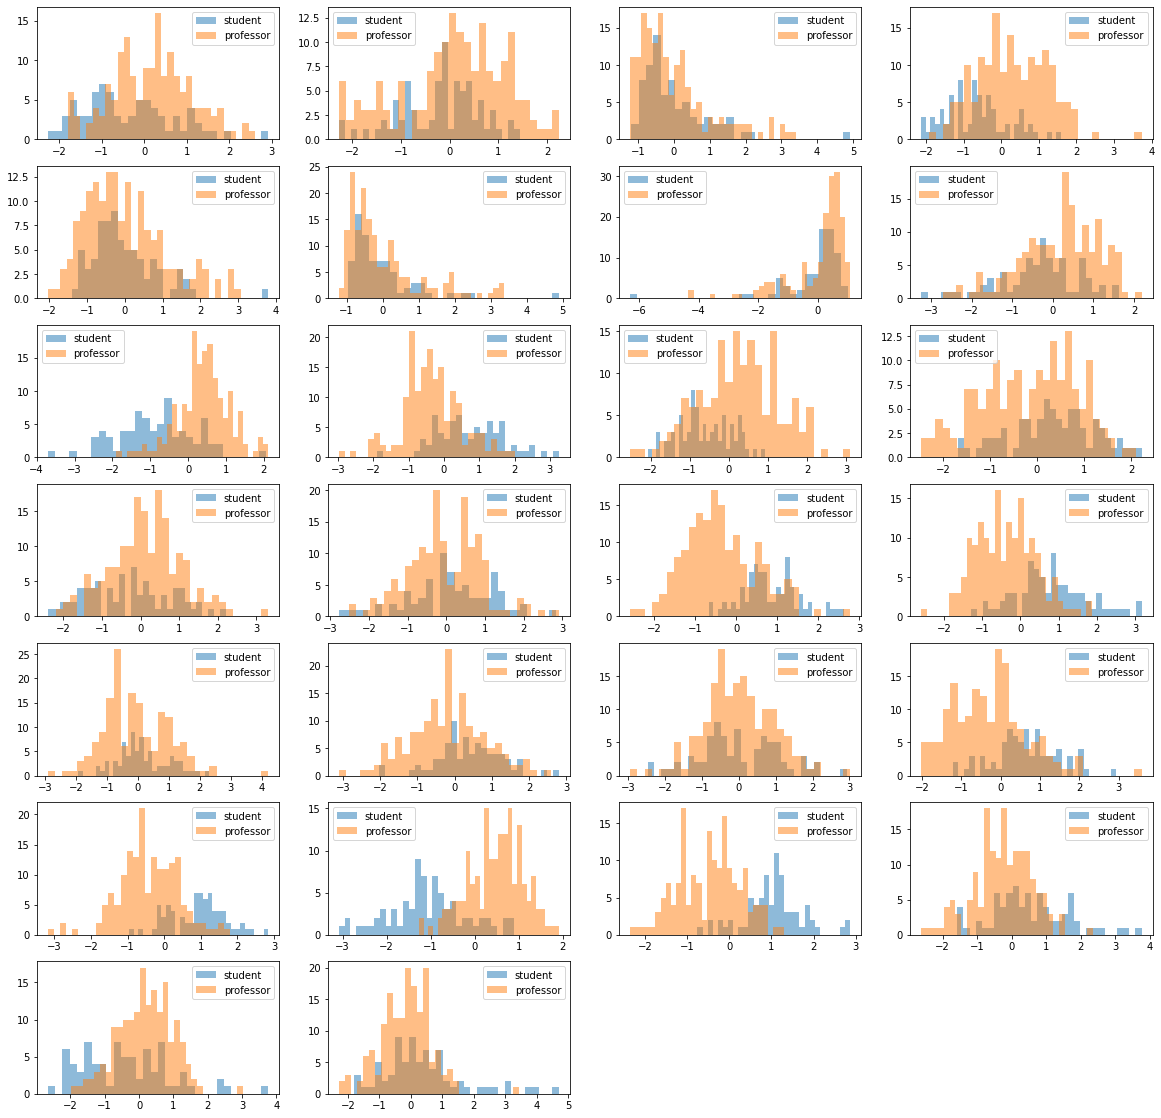

In [14]:
plt.figure(figsize=(20,20))
for i in range(0, feature_train_scaler.shape[1]):
    plt.subplot(7,4,i+1)
    plt.hist(feature_train_scaler[:,i][segments_target_train == 0], bins=30, alpha=0.5)
    plt.hist(feature_train_scaler[:,i][segments_target_train == 1], bins=30, alpha=0.5)
    plt.legend(['student', 'professor'])
plt.show()

# Model

In [15]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## Model - SVC

In [16]:
model_svc = SVC(C=0.1)
model_svc.fit(feature_train_scaler, segments_target_train)

SVC(C=0.1)

In [17]:
pred = model_svc.predict(feature_test_scaler)
print(classification_report(segments_target_test, pred, target_names=['student', 'professor']))

              precision    recall  f1-score   support

     student       1.00      0.89      0.94        19
   professor       0.95      1.00      0.98        42

    accuracy                           0.97        61
   macro avg       0.98      0.95      0.96        61
weighted avg       0.97      0.97      0.97        61



## Model - RandomForestClassifier

In [18]:
model_rfc = RandomForestClassifier(random_state=13)
model_rfc.fit(feature_train_scaler, segments_target_train)

RandomForestClassifier(random_state=13)

In [19]:
pred = model_rfc.predict(feature_test_scaler)
print(classification_report(segments_target_test, pred, target_names=['student', 'professor']))

              precision    recall  f1-score   support

     student       1.00      1.00      1.00        19
   professor       1.00      1.00      1.00        42

    accuracy                           1.00        61
   macro avg       1.00      1.00      1.00        61
weighted avg       1.00      1.00      1.00        61



# Segmenting student and teacher audio in test data 

In [20]:
def read_and_reshape_sound(path, segment_size_t = 0.5):
    # load
    sound, sr = librosa.load(path)

    signal_len = len(sound)
    # segment size in samples
    segment_size = int(segment_size_t * sr)
    # Break signal into list of segments in a single-line Python code
    segments = np.array([sound[x:x + segment_size] for x in np.arange(0, signal_len, segment_size)])
    return segments, sr

In [22]:
path = 'dataset/test/test.wav'
segment_size_t = 0.5
segments, sr = read_and_reshape_sound(path, segment_size_t)

display(Audio(np.concatenate(segments), rate=sr))

In [23]:
feature_valid = create_feature(segments, sr)
feature_valid_scaler = scaler.transform(feature_valid)
feature_valid_scaler.shape

(55, 26)

In [24]:
pred = model_rfc.predict(feature_valid_scaler)
pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

## Segmenting audio student and teacher

In [25]:
student_sound = np.concatenate(segments[pred == 0])
professor_sound = np.concatenate(segments[pred == 1])

## Student segmented sound 

In [26]:
display(Audio(student_sound, rate=sr))

## Professor segmented sound 

In [27]:
display(Audio(professor_sound, rate=sr))